In [ ]:
from google.colab import files
from pathlib import Path


if not Path(r"/content/heart+disease.zip"):
  # Pobranie pliku z lokalnego komputera na dysk Google Colab
  uploaded = files.upload()

  for filename in uploaded.keys():
      with open(filename, 'wb') as f:
          f.write(uploaded[filename])

  print(f"Plik {filename} został przesłany i zapisany w domyślnym miejscu na dysku Google Colab.")


In [ ]:
import zipfile
from pathlib import Path

def open_zip_file(zip_file_path, extraction_path):
    extracted_folder_path = Path(extraction_path)
    print(extracted_folder_path)
    if extracted_folder_path.exists():
      print("Folder juz istnieje")
    else:
      try:
          # Otwarcie pliku ZIP
          with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
              # Wylistowanie zawartości pliku ZIP
              zip_ref.printdir()
              # Wypakowanie wszystkich plików
              zip_ref.extractall(extraction_path)

          print("Plik ZIP został otwarty pomyślnie.")
      except zipfile.BadZipFile:
          print("Plik nie jest prawidłowym plikiem ZIP.")
      except FileNotFoundError:
          print("Nie można odnaleźć podanego pliku ZIP.")

    return extracted_folder_path

In [ ]:
extracted_folder_path = open_zip_file(zip_file_path='heart+disease.zip',
                                      extraction_path='Heart Disease Dataset')

Heart Disease Dataset
Folder juz istnieje


In [ ]:
# krzywa ROC from scrach
import numpy as np

def ROC_graph(Y_true, prediction_prob):
  """
  Funckja rysuje wykres ROC na podsawie prawidzywich danych i uch predykcji
  @param Y_true: prawdziwy wartosc uzyskana
  @param predict: dane otzymane na podstwie wyszkolenego modelu (prawdopodobienstow przynalerznosci do danej klasy)
  @return dwu elementowa liste zawierajaca false_pos_rate i true_pos_rate
  """
  pos_prob = prediction_prob[:, 1]
  thresholds = np.arange(0.0, 1.1, 0.05)
  true_pos, false_pos = [0]*len(thresholds), [0]*len(thresholds)
  for pred, y in zip(pos_prob, Y_true):
    for i, threshold in enumerate(thresholds):
      if pred >= threshold:
        if y == 1:
          true_pos[i] += 1
        else:
          false_pos[i] += 1
      else:
        break

  n_pos_test = (Y_true == 1).sum()
  n_neg_test = (Y_true == 0).sum()

  true_pos_rate = [tp / n_pos_test for tp in true_pos]
  false_pos_rate = [fp / n_neg_test for fp in false_pos]

  return true_pos_rate, false_pos_rate

In [ ]:
def accuracy_fun(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct/len(y_pred))*100
  return acc

In [ ]:
weights = {
    'age': 7,
    'sex': 4,
    'cp': 5,
    'trestbps': 7,
    'chol': 7,
    'fbs': 5,
    'thaloch': 8,
    'restecg': 10,
    'exang': 10,
    'oldpeak': 6,
    'slope': 4,
    'ca': 1,
    'thal': 1,
    'target': 1
}

categorical_list = list(weights.keys())
weights_list = list(weights.values())

print(categorical_list)
print(weights_list)

['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'thaloch', 'restecg', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target']
[7, 4, 5, 7, 7, 5, 8, 10, 10, 6, 4, 1, 1, 1]


In [ ]:
import pandas as pd
from pathlib import Path

def downlowad_data(path: str,
                   categorical: list,
                   weights: list = None):
    """
    Funkcja otwiera plik, oczyszcza z niepotrzebnych elementów
    i skaluje wartości między podanym zakresem.
    Zwraca data frama oraz słownik, gdzie kluczami są
    nazwy usuniętych kolumn, a wartościami są ich indeksy.

    @param path: ścieżka do pliku
    @param categorical: nazwy kolumn
    @return: mapa danych i wartosc wyjscowa
    """

    # przerobienie strina na obiekt typu Path
    path = Path(path)
    # pobranie danych z pliku
    df = pd.read_csv(path)
    # dodanie nagowko do kolumny
    df.columns = categorical

    # utworzenie data frame o krztałscie df ale zamias zmienej mamy typ zmienien
    types = df.dtypes

    # indexy kolum które nie zawieraja znaiej innej niz floath i int
    non_numeric_columns = types[types != 'float64'][types != 'int64'].index

    # przerbienie ostaniej kolumny (targets)
    df.loc[:, categorical[-1]] = df.loc[:, categorical[-1]].apply(lambda x: 0 if x==0 else 1)

    # Usunięcie kolumn w ktorych nie ma samych numerycznych danych
    df = df.drop(columns=non_numeric_columns)

    # przeksztalcenie df na liste
    non_numeric_columns = list(non_numeric_columns)

    # usuniecie z listy elemnetow ktore zosatlu usuniete z daa frame
    indexes = [categorical.index(item) for item in non_numeric_columns if item in categorical]
    categorical = list(filter(lambda x: x not in non_numeric_columns, categorical))

    if weights is not None:
      weights_copy = weights.copy()

      for i in indexes:
        weights_copy.remove(i)

      for weight, col_num in zip(weights_copy, range(df.shape[1])):
        df.iloc[:, col_num] = df.iloc[:, col_num] * weight
    # tworzenie mapy 0 i 1
    encoded_df = pd.get_dummies(df, columns=categorical[:-1])

    # Podzial danych na cechy i wartosc docelowa
    X = encoded_df.drop(categorical[-1],  axis=1)
    y = encoded_df[categorical[-1]]

    return X, y

In [ ]:
len(weights_list)

14

In [ ]:
path = r"/content/Heart Disease Dataset/processed.hungarian.data"
X, y = downlowad_data(path, categorical_list)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# pdozial na dane treningowe i testowe
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = MinMaxScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [ ]:
# uzucie naiwnego klasyfikatora Bayesa
from sklearn.naive_bayes import MultinomialNB

clf = MultinomialNB(alpha=1.0, fit_prior = True)
clf.fit(X_train, Y_train)

prediction_proba = clf.predict_proba(X_test)
prediction_proba[:5]

array([[0.91004748, 0.08995252],
       [0.08461255, 0.91538745],
       [0.9835034 , 0.0164966 ],
       [0.3018246 , 0.6981754 ],
       [0.98722589, 0.01277411]])

In [ ]:
prediction = clf.predict(X_test)
prediction[:5]

array([0, 1, 0, 1, 0])

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [ ]:
# dokladnosc modelu
acc = clf.score(X_test, Y_test)
print(f"Dokładnosc modelu {acc*100:.1f}%")

Dokładnosc modelu 83.1%


In [ ]:
true_pos_rate, false_pos_rate = ROC_graph(Y_true=Y_test,
                                          prediction_prob=prediction_proba)

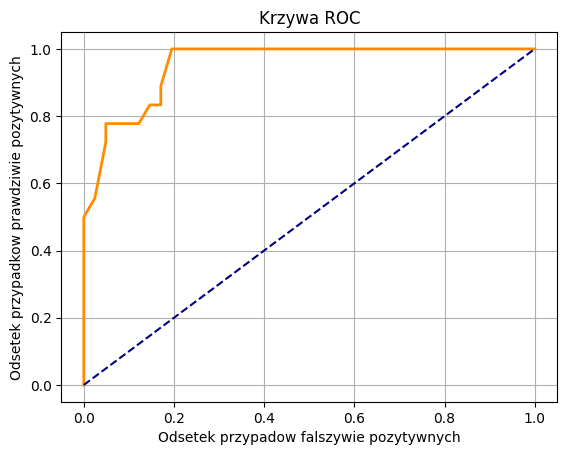

In [ ]:
# rysiwanie wykresu ROC
import matplotlib.pyplot as plt
plt.figure()
lw = 2
plt.plot(false_pos_rate, true_pos_rate, color='darkorange', lw=lw)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel("Odsetek przypadow falszywie pozytywnych")
plt.ylabel("Odsetek przypadkow prawdziwie pozytywnych")
plt.title("Krzywa ROC")
plt.grid(True)
plt.show()

In [ ]:
print(classification_report(Y_test, prediction))

              precision    recall  f1-score   support

           0       0.92      0.83      0.87        41
           1       0.68      0.83      0.75        18

    accuracy                           0.83        59
   macro avg       0.80      0.83      0.81        59
weighted avg       0.85      0.83      0.83        59



In [ ]:
print(confusion_matrix(Y_test, prediction))

[[34  7]
 [ 3 15]]


In [ ]:
accuracy_score(Y_test, prediction)

0.8305084745762712

In [ ]:
X_with_weight, Y = downlowad_data(path, categorical_list)

In [ ]:
# Podzial danych na train i test
X_train_w, X_test_w, Y_train_w, Y_test_w = train_test_split(X_with_weight, Y, test_size=0.2, random_state=42)

scaler = MinMaxScaler()

X_train_w = scaler.fit_transform(X_train_w)
X_test_w = scaler.transform(X_test_w)

In [ ]:
# urzycie naiwnego bayessa

clf = MultinomialNB()
clf.fit(X_train_w, Y_train_w)

prediction_proba_w = clf.predict_proba(X_test_w)
prediction_proba_w[:5]

array([[0.91004748, 0.08995252],
       [0.08461255, 0.91538745],
       [0.9835034 , 0.0164966 ],
       [0.3018246 , 0.6981754 ],
       [0.98722589, 0.01277411]])

In [ ]:
prediction = clf.predict(X_test_w)
prediction[:5]

array([0, 1, 0, 1, 0])

In [ ]:
acc_w = clf.score(X_test_w, Y_test_w)
print(f"Dokładnosc modelu {acc_w*100:.1f}%")

Dokładnosc modelu 83.1%


In [ ]:
# maciuerz bledu
print(confusion_matrix(Y_test_w, prediction))

[[34  7]
 [ 3 15]]


In [ ]:
print(classification_report(Y_test_w, prediction))

              precision    recall  f1-score   support

           0       0.92      0.83      0.87        41
           1       0.68      0.83      0.75        18

    accuracy                           0.83        59
   macro avg       0.80      0.83      0.81        59
weighted avg       0.85      0.83      0.83        59



In [ ]:
true_pos_rate, false_pos_rate = ROC_graph(Y_true=Y_test_w,
                                          prediction_prob=prediction_proba)

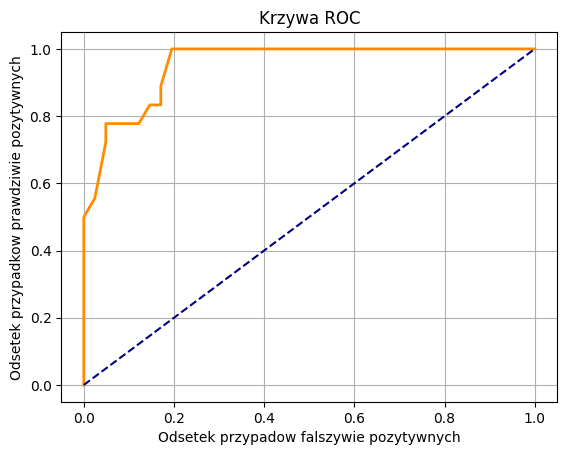

In [ ]:
# rysiwanie wykresu ROC
import matplotlib.pyplot as plt
plt.figure()
lw = 2
plt.plot(false_pos_rate, true_pos_rate, color='darkorange', lw=lw)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel("Odsetek przypadow falszywie pozytywnych")
plt.ylabel("Odsetek przypadkow prawdziwie pozytywnych")
plt.title("Krzywa ROC")
plt.grid(True)
plt.show()

In [ ]:
### Siec neuronowa
import torch
from torch import nn

class Model_heart_diseases(nn.Module):
  def __init__(self, input_shape: int,
                     hidden_unit: int,
                     output_shape: int):
    super().__init__()
    self.block_1 = nn.Sequential(
                   nn.Linear(in_features=input_shape,
                             out_features=2*hidden_unit),
                   nn.ReLU(),
                   nn.Linear(in_features=2*hidden_unit,
                             out_features=4*hidden_unit),
                   nn.ReLU(),
                   nn.Linear(in_features=4*hidden_unit,
                             out_features=output_shape),
                   nn.LeakyReLU(),
                   #nn.Dropout(0.1)
    )

  def forward(self, x:torch.Tensor) -> torch.Tensor:
    return self.block_1(x)

In [ ]:
X_train.shape

(234, 53)

In [ ]:
torch.manual_seed(42)
Model0 = Model_heart_diseases(X_train.shape[1], 200, 2)

In [ ]:
optimizer = torch.optim.Adam(params=Model0.parameters(),
                             lr = 0.01)

loss_fn = nn.CrossEntropyLoss()


In [ ]:
X_train = torch.tensor(X_train).float()
X_test = torch.tensor(X_test).float()
Y_train = torch.tensor(Y_train.values).long()
Y_test = torch.tensor(Y_test.values).long()

len(X_train), len(X_test), len(Y_train), len(Y_test)


(234, 59, 234, 59)

In [ ]:
torch.manual_seed(42)
Model1 = Model_heart_diseases(X_train.shape[1], 100, 2)

optimizer_1 = torch.optim.Adam(params=Model1.parameters(),
                             lr = 0.01)

loss_fn = nn.CrossEntropyLoss()

max_test = 0
losses = []
best_params = Model1.state_dict()
for epoch in range(1, 50):
    optimizer_1.zero_grad()
    outputs = Model1(X_train)
    loss = loss_fn(outputs, Y_train)
    loss.backward()
    optimizer_1.step()
    losses.append(loss.item())
    _, preds_y = torch.max(outputs, 1)
    train_acc = accuracy_score(Y_train, preds_y)

    pred_test = Model1(X_test)
    _, preds_test_y = torch.max(pred_test, 1)
    test_acc = accuracy_score(Y_test, preds_test_y)
    print("Epoch {}, Loss: {}, Acc:{:.2f}%, Test Acc: {:.2f}%".format(epoch, loss.item(),
                                                                      train_acc*100, test_acc * 100))
    if test_acc > max_test:
        max_test = test_acc
        best_params = Model1.state_dict()
Model1.load_state_dict(best_params)


Epoch 1, Loss: 0.6879039406776428, Acc:62.39%, Test Acc: 69.49%
Epoch 2, Loss: 0.6001794338226318, Acc:62.39%, Test Acc: 89.83%
Epoch 3, Loss: 0.5044329762458801, Acc:79.06%, Test Acc: 84.75%
Epoch 4, Loss: 0.41855838894844055, Acc:85.04%, Test Acc: 84.75%
Epoch 5, Loss: 0.37321197986602783, Acc:83.33%, Test Acc: 86.44%
Epoch 6, Loss: 0.3415115177631378, Acc:87.18%, Test Acc: 86.44%
Epoch 7, Loss: 0.3024540841579437, Acc:87.18%, Test Acc: 84.75%
Epoch 8, Loss: 0.2608329951763153, Acc:90.17%, Test Acc: 83.05%
Epoch 9, Loss: 0.23473532497882843, Acc:90.17%, Test Acc: 81.36%
Epoch 10, Loss: 0.2186037302017212, Acc:90.17%, Test Acc: 77.97%
Epoch 11, Loss: 0.20089322328567505, Acc:91.45%, Test Acc: 79.66%
Epoch 12, Loss: 0.17941857874393463, Acc:93.16%, Test Acc: 81.36%
Epoch 13, Loss: 0.1657906174659729, Acc:91.88%, Test Acc: 83.05%
Epoch 14, Loss: 0.1568221002817154, Acc:92.74%, Test Acc: 83.05%
Epoch 15, Loss: 0.1434294432401657, Acc:92.74%, Test Acc: 79.66%
Epoch 16, Loss: 0.13414101302

<All keys matched successfully>

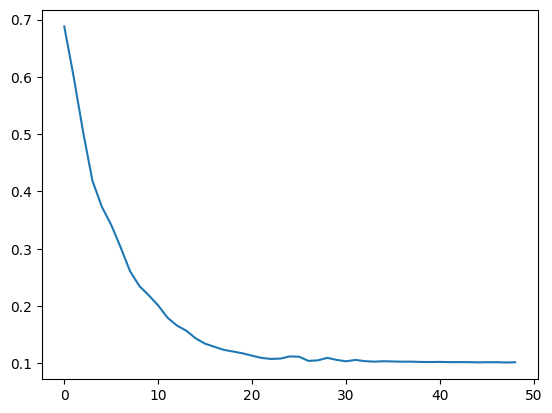

In [ ]:
plt.plot(losses)

In [ ]:

epochs = 20
losses = []
max_test = 0

for epoch in range(epochs):
    ### trenowanie
    Model0.train()

    pred_logits = Model0(X_train).squeeze(dim=1)
    pred = torch.argmax(pred_logits, dim=1)  # Zmiana: Użyj torch.argmax

    loss = loss_fn(pred_logits, Y_train)
    losses.append(loss.item())
    acc = accuracy_score(Y_train, pred)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Walidacja
    Model0.eval()
    with torch.no_grad():
        test_logits = Model0(X_test).squeeze(dim=1)
        test_pred = torch.argmax(test_logits, dim=1)

        test_loss = loss_fn(test_logits, Y_test)
        test_acc = accuracy_score(Y_test, test_pred)

        if test_acc > max_test:
            max_test = test_acc
            best_params = Model0.state_dict()

    if epoch % 1 == 0:
        print(f"epoch: {epoch} | loss: {loss:.5f} | test_loss: {test_loss:.5f} | accuracy: {acc*100:.2f}% | test_accuracy: {test_acc*100:.2f}%")
Model1.load_state_dict(best_params)

epoch: 0 | loss: 0.69349 | test_loss: 0.56544 | accuracy: 37.61% | test_accuracy: 69.49%
epoch: 1 | loss: 0.60693 | test_loss: 0.37051 | accuracy: 62.39% | test_accuracy: 72.88%
epoch: 2 | loss: 0.50775 | test_loss: 0.48970 | accuracy: 69.23% | test_accuracy: 83.05%
epoch: 3 | loss: 0.50890 | test_loss: 0.31777 | accuracy: 85.47% | test_accuracy: 88.14%
epoch: 4 | loss: 0.36540 | test_loss: 0.35727 | accuracy: 82.48% | test_accuracy: 84.75%
epoch: 5 | loss: 0.37979 | test_loss: 0.31872 | accuracy: 83.33% | test_accuracy: 84.75%
epoch: 6 | loss: 0.34359 | test_loss: 0.33345 | accuracy: 84.62% | test_accuracy: 86.44%
epoch: 7 | loss: 0.29796 | test_loss: 0.36821 | accuracy: 86.75% | test_accuracy: 83.05%
epoch: 8 | loss: 0.26197 | test_loss: 0.40694 | accuracy: 87.61% | test_accuracy: 83.05%
epoch: 9 | loss: 0.25704 | test_loss: 0.41227 | accuracy: 87.61% | test_accuracy: 81.36%
epoch: 10 | loss: 0.24486 | test_loss: 0.41520 | accuracy: 88.89% | test_accuracy: 81.36%
epoch: 11 | loss: 0.

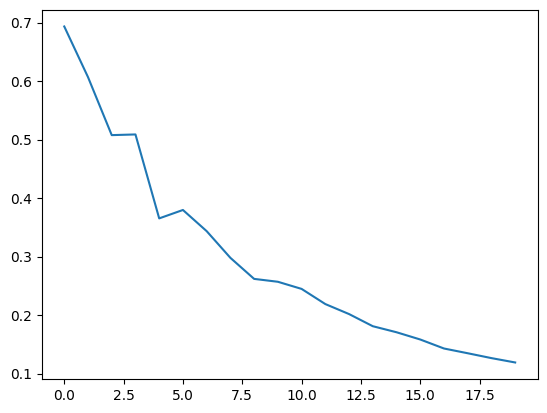

In [ ]:
plt.plot(losses)